__Probing Language Models__

This notebook serves as a start for your NLP2 assignment on probing Language Models. This notebook will become part of the contents that you will submit at the end, so make sure to keep your code (somewhat) clean :-)

__note__: This is only the second time anyone is doing this assignment. That's exciting! But it might well be the case that certain aspects are too unclear. Do not hesitate at all to reach to me once you get stuck, I'd be grateful to help you out.

__note 2__: This assignment is not dependent on big fancy GPUs. I run all this stuff on my own 3 year old CPU, without any Colab hassle. So it's up to you to decide how you want to run it.

# Models

For the Transformer models you are advised to make use of the `transformers` library of Huggingface: https://github.com/huggingface/transformers
Their library is well documented, and they provide great tools to easily load in pre-trained models.

In [1]:
#
## Your code for initializing the transformer model(s)
#
# Note that most transformer models use their own `tokenizer`, that should be loaded in as well.
#
from transformers import GPT2Tokenizer, GPT2Model



model = GPT2Model.from_pretrained('distilgpt2')
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2', output_hidden_states=True)


# Note that some models don't return the hidden states by default.
# This can be configured by passing `output_hidden_states=True` to the `from_pretrained` method.

Some weights of GPT2Model were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.5.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
#
## Your code for initializing the rnn model(s)
#
# The Gulordava LSTM model can be found here: 
# https://drive.google.com/file/d/19Lp3AM4NEPycp_IBgoHfLc_V456pmUom/view?usp=sharing
#
# N.B: I have altered the RNNModel code to only output the hidden states that you are interested in.
# If you want to do more experiments with this model you could have a look at the original code here:
# https://github.com/facebookresearch/colorlessgreenRNNs/blob/master/src/language_models/model.py
#
from collections import defaultdict
from lstm.model import RNNModel
import torch


model_location = 'gulordava/state_dict.pt'  # <- point this to the location of the Gulordava .pt file
lstm = RNNModel('LSTM', 50001, 650, 650, 2)
lstm.load_state_dict(torch.load(model_location))


# This LSTM does not use a Tokenizer like the Transformers, but a Vocab dictionary that maps a token to an id.
with open('lstm/vocab.txt', encoding='ISO-8859-1') as f:
    w2i = {w.strip(): i for i, w in enumerate(f)}

vocab = defaultdict(lambda: w2i["<unk>"])
vocab.update(w2i)

It is a good idea that before you move on, you try to feed some text to your LMs; and check if everything works accordingly. 

# Data

For this assignment you will train your probes on __treebank__ corpora. A treebank is a corpus that has been *parsed*, and stored in a representation that allows the parse tree to be recovered. Next to a parse tree, treebanks also often contain information about part-of-speech tags, which is exactly what we are after now.

The treebank you will use for now is part of the Universal Dependencies project. I provide a sample of this treebank as well, so you can test your setup on that before moving on to larger amounts of data.

Make sure you accustom yourself to the format that is created by the `conllu` library that parses the treebank files before moving on. For example, make sure you understand how you can access the pos tag of a token, or how to cope with the tree structure that is formed using the `to_tree()` functionality.

In [3]:
# READ DATA
from typing import List
from conllu import parse_incr, TokenList


# If stuff like `: str` and `-> ..` seems scary, fear not! 
# These are type hints that help you to understand what kind of argument and output is expected.
def parse_corpus(filename: str) -> List[TokenList]:
    '''Have every sentence become a TokenList.
    
    A token is a dictionary representing a word in a sentence. A token contains the following:\n
    <str> deprel: \n
    <list> deps: \n
    <dict> feats: {
        <str> Definite: \n
        <str> PronType: \n
    }
    <str> form: \n
    <int> head: \n
    <int> id: \n
    <str> lemma: \n
    <None> misc: \n
    <str> upos: \n
    <str> xpon: \n
    '''
    data_file = open(filename, encoding="utf-8")

    ud_parses = list(parse_incr(data_file))
    
    return ud_parses

# Generating Representations

We now have our data all set, our models are running and we are good to go!

The next step is now to create the model representations for the sentences in our corpora. Once we have generated these representations we can store them, and train additional diagnostic (/probing) classifiers on top of the representations.

There are a few things you should keep in mind here. Read these carefully, as these tips will save you a lot of time in your implementation.
1. Transformer models make use of Byte-Pair Encodings (BPE), that chunk up a piece of next in subword pieces. For example, a word such as "largely" could be chunked up into "large" and "ly". We are interested in probing linguistic information on the __word__-level. Therefore, we will follow the suggestion of Hewitt et al. (2019a, footnote 4), and create the representation of a word by averaging over the representations of its subwords. So the representation of "largely" becomes the average of that of "large" and "ly".


2. Subword chunks never overlap multiple tokens. In other words, say we have a phrase like "None of the", then the tokenizer might chunk that into "No"+"ne"+" of"+" the", but __not__ into "No"+"ne o"+"f the", as those chunks overlap multiple tokens. This is great for our setup! Otherwise it would have been quite challenging to distribute the representation of a subword over the 2 tokens it belongs to.


3. **Important**: If you closely examine the provided treebank, you will notice that some tokens are split up into multiple pieces, that each have their own POS-tag. For example, in the first sentence the word "Al-Zaman" is split into "Al", "-", and "Zaman". In such cases, the conllu `TokenList` format will add the following attribute: `('misc', OrderedDict([('SpaceAfter', 'No')]))` to these tokens. Your model's tokenizer does not need to adhere to the same tokenization. E.g., "Al-Zaman" could be split into "Al-"+"Za"+"man", making it hard to match the representations with their correct pos-tag. Therefore I recommend you to not tokenize your entire sentence at once, but to do this based on the chunking of the treebank. <br /><br />
Make sure to still incoporate the spaces in a sentence though, as these are part of the BPE of the tokenizer. That is, the tokenizer uses a different token id for `"man"`, than it does for `" man"`: the former could be part of `" woman"`=`" wo`"+`"man"`, whereas the latter would be the used in case *man* occurs at the start of a word. The tokenizer for GPT-2 adds spaces at the start of a token (represented as a `Ġ` symbol). This means that you should keep track whether the previous token had the `SpaceAfter` attribute set to `'No'`: in case it did not, you should manually prepend a `" "` ahead of the token.


4. The LSTM LM does not have the issues related to subwords, but is far more restricted in its vocabulary. Make sure you keep the above points in mind though, when creating the LSTM representations. You might want to write separate functions for the LSTM, but that is up to you.


5. **N.B.**: Make sure that when you run a sentence through your model, you do so within a `with torch.no_grad():` block, and that you have run `model.eval()` beforehand as well (to disable dropout).


6. **N.B.**: Make sure to use a token's ``["form"]`` attribute, and not the ``["lemma"]``, as the latter will stem any relevant morphological information from the token. We don't want this, because we want to feed well-formed, grammatical sentences to our model.


I would like to stress that if you feel hindered in any way by the simple code structure that is presented here, you are free to modify it :-) Just make sure it is clear to an outsider what you're doing, some helpful comments never hurt.

In [4]:
# FETCH SENTENCE REPRESENTATIONS
from torch import Tensor
import pickle


# Should return a tensor of shape (num_tokens_in_corpus, representation_size)
# Make sure you correctly average the subword representations that belong to 1 token!

def fetch_sen_reps(ud_parses: List[TokenList], model, tokenizer, concat=True) -> Tensor:
    # check which function to use
    if isinstance(model, GPT2Model):
        representations = fetch_sen_reps_transformer(ud_parses, model, tokenizer, concat)
    else:
        representations = fetch_sen_reps_lstm(ud_parses, model, tokenizer, concat)
    
    # return the representations
    return representations

def fetch_sen_reps_transformer(ud_parses: List[TokenList], model, tokenizer, concat_sentences) -> Tensor:
    full_representation = []
    
    # loop over the parsed sentences
    for sentence in ud_parses:
        space_after = 'No'
        sentence_ids = []
        subword_dict = {}
        chunk_offset = 0
        
        # loop over the words in the parsed sentence
        for word_index, word in enumerate(sentence):
            # check if the previous word had a space after
            if (space_after == 'No'):
                token = word['form']
            else:
                token = " " + word['form']
            if (word['misc'] is not None):
                if ('SpaceAfter' in word['misc']):
                    space_after = word['misc']['SpaceAfter']
                else:
                    space_after = 'Yes'
            else:
                space_after = 'Yes'
                
            # tokenize the word
            tokenized_word = tokenizer(token, return_tensors='pt')
            subword_ids = tokenized_word['input_ids']
            
            # check if multiple subwords
            if (subword_ids.shape[1] > 1):
                chunk_index_list = []
                chunks = torch.chunk(subword_ids, subword_ids.shape[1], dim=1)
                for chunk_index, chunk in enumerate(chunks):
                    sentence_ids.append(chunk)
                    chunk_index_list.append(word_index + chunk_index + chunk_offset)
                chunk_offset += len(chunk_index_list) -1
                subword_dict[word_index] = chunk_index_list
            else:
                subword_dict[word_index] = [word_index + chunk_offset]
                sentence_ids.append(subword_ids)
        
        # pass the sentence through the model
        sentence_ids = torch.cat(sentence_ids, dim=1)
        model.eval()
        with torch.no_grad():
            sentence_representation = model(sentence_ids)
            sentence_representation = sentence_representation.last_hidden_state
        
        # mean the subwords into one word representation
        sentence_representation = sentence_representation.squeeze(dim=0)
        new_sentence_representation = [torch.mean(sentence_representation.index_select(0, torch.tensor(chunks)), dim=0)
                                       for chunks in subword_dict.values()]
        new_sentence_representation = torch.stack(new_sentence_representation, dim=0)
        
        # add to the list of sentence representations
        full_representation.append(new_sentence_representation)
    
    # check whether to concat the sentences or not
    if concat_sentences:
        # concatenate the sentence representations into one big tensor
        full_representation = torch.cat(full_representation, dim=0)
    
    # return the full representation
    return full_representation

def fetch_sen_reps_lstm(ud_parses: List[TokenList], model, tokenizer, concat_sentences) -> Tensor:
    full_representation = []
    
    # loop over the parsed sentences
    for sentence in ud_parses:
        sentence_ids = []
        
        # loop over the words in the parsed sentence
        for word in sentence:          
            # tokenize the word
            token_id = tokenizer[word['form']]
            token_id = torch.tensor([[token_id]])
            sentence_ids.append(token_id)
            
        # pass the sentence through the model
        sentence_ids = torch.cat(sentence_ids, dim=1)
        model.eval()
        with torch.no_grad():
            # generate a hidden state
            hidden_state = model.init_hidden(sentence_ids.shape[0])
            # take the representation of the sentence
            sentence_representation = model(sentence_ids, hidden_state)
        
         # check if only 1 sentence
        sentence_representation = sentence_representation.squeeze(dim=0)
        if (len(ud_parses) == 1):
            # return the sentence representation
            return sentence_representation
        else:
            # add to the list of sentence representations
            full_representation.append(sentence_representation)
    
    # check whether to concat the sentences or not
    if concat_sentences:
        # concatenate the sentence representations into one big tensor
        full_representation = torch.cat(full_representation, dim=0)
    
    # return the full representation
    return full_representation

To validate your activation extraction procedure I have set up the following assertion function as a sanity check. It compares your representation against a pickled version of mine. 

For this I used `distilgpt2`.

In [5]:
def error_msg(model_name, gold_embs, embs, i2w):
    with open(f'{model_name}_tokens1.pickle', 'rb') as f:
        sen_tokens = pickle.load(f)
        
    diff = torch.abs(embs - gold_embs)
    max_diff = torch.max(diff)
    avg_diff = torch.mean(diff)
    
    print(f"{model_name} embeddings don't match!")
    print(f"Max diff.: {max_diff:.4f}\nMean diff. {avg_diff:.4f}")

    print("\nCheck if your tokenization matches with the original tokenization:")
    for idx in sen_tokens.squeeze():
        if isinstance(i2w, list):
            token = i2w[idx]
        else:
            token = i2w.convert_ids_to_tokens(idx.item())
        print(f"{idx:<6} {token}")


def assert_sen_reps(model, tokenizer, lstm, vocab):
    with open('distilgpt2_emb1.pickle', 'rb') as f:
        distilgpt2_emb1 = pickle.load(f)
        
    with open('lstm_emb1.pickle', 'rb') as f:
        lstm_emb1 = pickle.load(f)
    
    corpus = parse_corpus('data/sample/en_ewt-ud-train.conllu')[:1]
    
    own_distilgpt2_emb1 = fetch_sen_reps(corpus, model, tokenizer)
    own_lstm_emb1 = fetch_sen_reps(corpus, lstm, vocab)
    
    assert distilgpt2_emb1.shape == own_distilgpt2_emb1.shape, \
        f"Distilgpt2 shape mismatch: {distilgpt2_emb1.shape} (gold) vs. {own_distilgpt2_emb1.shape} (yours)"
    assert lstm_emb1.shape == own_lstm_emb1.shape, \
        f"LSTM shape mismatch: {lstm_emb1.shape} (gold) vs. {own_lstm_emb1.shape} (yours)"

    if not torch.allclose(distilgpt2_emb1, own_distilgpt2_emb1, rtol=1e-3, atol=1e-3):
        error_msg("distilgpt2", distilgpt2_emb1, own_distilgpt2_emb1, tokenizer)
    if not torch.allclose(lstm_emb1, own_lstm_emb1, rtol=1e-3, atol=1e-3):
        error_msg("lstm", lstm_emb1, own_lstm_emb1, list(vocab.keys()))


assert_sen_reps(model, tokenizer, lstm, vocab)

Next, we should define a function that extracts the corresponding POS labels for each activation, which we do based on the **``"upostag"``** attribute of a token (so not the ``xpostag`` attribute). These labels will be transformed to a tensor containing the label index for each item.

In [6]:
# FETCH POS LABELS


# Should return a tensor of shape (num_tokens_in_corpus,)
# Make sure that when fetching these pos tags for your train/dev/test corpora you share the label vocabulary.
def fetch_pos_tags(ud_parses: List[TokenList], pos_vocab=None) -> Tensor:
    # check if the vocabulary is None
    if pos_vocab is None:
        # create a new vocab
        pos_vocab = defaultdict()
        
        # word index is 0
        word_index = 0
    else:
        # word index is the length of the vocab
        word_index = len(pos_vocab)
    
    # create a list of tags from the input
    all_tags = []
    
    # loop over the parsed sentences
    for sentence in ud_parses:    
        # loop over the words in the parsed sentence
        for word in sentence:
            # get the tag
            tag = word['upostag']
            
            # check if the tag does not exist in the vocabulary
            if tag not in pos_vocab:
                # create a new entry
                pos_vocab[tag] = word_index
                
                # add to the word index
                word_index += 1
            
            # add tag to the tags list
            all_tags.append(torch.tensor(pos_vocab[tag]))
    
    # stack the tags into a tensor
    all_tags = torch.stack(all_tags, dim=0)
    
    # return the tags and vocabulary
    return all_tags, pos_vocab

In [25]:
import os

# Function that combines the previous functions, and creates 2 tensors for a .conllu file: 
# 1 containing the token representations, and 1 containing the (tokenized) pos_tags.

def create_data(filename: str, lm, w2i, pos_vocab=None):
    ud_parses = parse_corpus(filename)
    
    sen_reps = fetch_sen_reps(ud_parses, lm, w2i)
    pos_tags, pos_vocab = fetch_pos_tags(ud_parses, pos_vocab=pos_vocab)
    
    return sen_reps, pos_tags, pos_vocab


lm = model  # or `lstm`
w2i = tokenizer  # or `vocab`
use_sample = True

train_x, train_y, train_vocab = create_data(
    os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-train.conllu'),
    lm, 
    w2i
)

dev_x, dev_y, _ = create_data(
    os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-dev.conllu'),
    lm, 
    w2i,
    pos_vocab=train_vocab
)

test_x, test_y, _ = create_data(
    os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-test.conllu'),
    lm,
    w2i,
    pos_vocab=train_vocab
)

# Diagnostic Classification

We now have our models, our data, _and_ our representations all set! Hurray, well done. We can finally move onto the cool stuff, i.e. training the diagnostic classifiers (DCs).

DCs are simple in their complexity on purpose. To read more about why this is the case you could already have a look at the "Designing and Interpreting Probes with Control Tasks" by Hewitt and Liang (esp. Sec. 3.2).

A simple linear classifier will suffice for now, don't bother with adding fancy non-linearities to it.

I am personally a fan of the `skorch` library, that provides `sklearn`-like functionalities for training `torch` models, but you are free to train your dc using whatever method you prefer.

As this is an Artificial Intelligence master and you have all done ML1 + DL, I expect you to use your train/dev/test splits correctly ;-)

In [7]:
# DIAGNOSTIC CLASSIFIER
class DiagnosticClassifier(torch.nn.Module):
    def __init__(self, in_size, out_size, hidden_sizes):
        super().__init__()
        
        # initialize the layers of the model
        modules = []
        for hidden_size in hidden_sizes:
            modules.append(torch.nn.Linear(in_size, hidden_size))
            in_size = hidden_size
        modules.append(torch.nn.Linear(in_size, out_size))
        self.layers = torch.nn.Sequential(*modules)
            
        # add softmax
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        # pass x through the model
        out = self.layers(x)
        
        # run through the softmax
        out = self.softmax(out)
        
        # return the output
        return out

In [8]:
# check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [9]:
from skorch import NeuralNetClassifier
from sklearn.model_selection import train_test_split
from skorch.helper import predefined_split
from skorch.dataset import Dataset
from skorch.callbacks import EarlyStopping

# function to train the diagnostic classifier
def train_dc(diagnostic_classifier, train_x, train_y, device, batch_size=1, max_epochs=40, lr=3e-4, hidden_sizes=[]):
    # initialize the model
    net = NeuralNetClassifier(
        diagnostic_classifier,
        module__in_size=train_x[0].shape[0],
        module__out_size=train_y.shape[0],
        module__hidden_sizes=hidden_sizes,
        max_epochs=max_epochs,
        batch_size=batch_size,
        optimizer = torch.optim.Adam,
        optimizer__lr=lr,
        iterator_train__shuffle=True,
        criterion=torch.nn.NLLLoss,
        device=device,
        callbacks=[
            EarlyStopping(monitor='valid_loss', 
                          patience=3, 
                          threshold=0.0001, 
                          threshold_mode='rel', 
                          lower_is_better=True)
        ],
    )
    
    # train the model
    net.fit(train_x, train_y)
    
    # return the model
    return net

In [11]:
# combine train and validation datasets
x_train = torch.cat((train_x, dev_x), dim=0)
y_train = torch.cat((train_y, dev_y), dim=0)

# train the diagnostic classifier
trained_dc = train_dc(DiagnosticClassifier, x_train, y_train, device)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.4820       0.8228        0.6386  40.3620
      2        0.5523       0.8732        0.4574  41.0950
      3        0.3749       0.8890        0.4143  41.9730
      4        0.2891       0.8991        0.3336  43.8190
      5        0.2290       0.8790        0.3653  42.4185
      6        0.1919       0.9035        0.3347  42.2570
      7        0.1630       0.9049        0.3163  44.1735
      8        0.1430       0.9049        0.2978  42.2880
      9        0.1239       0.9049        0.3220  44.3989
     10        0.1114       0.9193        0.2987  50.4606
Stopping since valid_loss has not improved in the last 3 epochs.


# Trees

For our gold labels, we need to recover the node distances from our parse tree. For this we will use the functionality provided by `ete3`, that allows us to compute that directly. I have provided code that transforms a `TokenTree` to a `Tree` in `ete3` format.

In [10]:
# In case you want to transform your conllu tree to an nltk.Tree, for better visualisation

def rec_tokentree_to_nltk(tokentree):
    token = tokentree.token["form"]
    tree_str = f"({token} {' '.join(rec_tokentree_to_nltk(t) for t in tokentree.children)})"

    return tree_str


def tokentree_to_nltk(tokentree):
    from nltk import Tree as NLTKTree

    tree_str = rec_tokentree_to_nltk(tokentree)

    return NLTKTree.fromstring(tree_str)

In [11]:
# !pip install ete3
from ete3 import Tree as EteTree


class FancyTree(EteTree):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, format=1, **kwargs)
        
    def __str__(self):
        return self.get_ascii(show_internal=True)
    
    def __repr__(self):
        return str(self)


def rec_tokentree_to_ete(tokentree):
    idx = str(tokentree.token["id"])
    children = tokentree.children
    if children:
        return f"({','.join(rec_tokentree_to_ete(t) for t in children)}){idx}"
    else:
        return idx
    
def tokentree_to_ete(tokentree):
    newick_str = rec_tokentree_to_ete(tokentree)

    return FancyTree(f"{newick_str};")

In [12]:
# Let's check if it works!
# We can read in a corpus using the code that was already provided, and convert it to an ete3 Tree.

def parse_corpus(filename):
    from conllu import parse_incr

    data_file = open(filename, encoding="utf-8")

    ud_parses = list(parse_incr(data_file))
    
    return ud_parses

corpus = parse_corpus('data/sample/en_ewt-ud-train.conllu')
item = corpus[0]
tokentree = item.to_tree()
ete3_tree = tokentree_to_ete(tokentree)
print(ete3_tree)


   /-2
  |
  |--3
  |
  |--4
  |
  |   /6 /-5
  |  |
  |  |   /-9
  |  |  |
  |  |  |--10
  |  |  |
  |  |  |--11
  |  |-8|
  |  |  |--12
  |-7|  |
  |  |  |--13
  |  |  |
  |  |   \15/-14
-1|  |
  |  |   /-16
  |  |  |
  |  |  |--17
  |  |  |
  |   \18   /-19
  |     |  |
  |     |  |--20
  |     |  |
  |     |  |-23/-22
  |      \21
  |        |--24
  |        |
  |        |   /-25
  |        |  |
  |         \28--26
  |           |
  |            \-27
  |
   \-29


As you can see we label a token by its token id (converted to a string). Based on these id's we are going to retrieve the node distances.

To create the true distances of a parse tree in our treebank, we are going to use the `.get_distance` method that is provided by `ete3`: http://etetoolkit.org/docs/latest/tutorial/tutorial_trees.html#working-with-branch-distances

We will store all these distances in a `torch.Tensor`.

Please fill in the gap in the following method. I recommend you to have a good look at Hewitt's blog post  about these node distances.

In [13]:
def create_gold_distances(corpus):
    all_distances = []

    for item in (corpus):
        tokentree = item.to_tree()
        ete_tree = tokentree_to_ete(tokentree)

        sen_len = len(ete_tree.search_nodes())
        distances = torch.zeros((sen_len, sen_len))

        # Your code for computing all the distances comes here.
        
        # loop over the nodes in the tree
        for index_1, node_1 in enumerate(ete_tree.traverse("postorder")):
            node_distance = torch.zeros((1, sen_len))
            # get the distance of the node to all other nodes
            for index_2, node_2 in enumerate(ete_tree.traverse("postorder")):
                distance = node_1.get_distance(node_2.name)
                node_distance[0][index_2] = distance
            distances[index_1] = node_distance

        all_distances.append(distances)

    return all_distances

The next step is now to do the previous step the other way around. After all, we are mainly interested in predicting the node distances of a sentence, in order to recreate the corresponding parse tree.

Hewitt et al. reconstruct a parse tree based on a _minimum spanning tree_ (MST, https://en.wikipedia.org/wiki/Minimum_spanning_tree). Fortunately for us, we can simply import a method from `scipy` that retrieves this MST.

In [14]:
from scipy.sparse.csgraph import minimum_spanning_tree
import torch


def create_mst(distances):
    distances = torch.triu(distances).detach().numpy()
    
    mst = minimum_spanning_tree(distances).toarray()
    mst[mst>0] = 1.
    
    return mst

Let's have a look at what this looks like, by looking at a relatively short sentence in the sample corpus.

If your addition to the `create_gold_distances` method has been correct, you should be able to run the following snippet. This then shows you the original parse tree, the distances between the nodes, and the MST that is retrieved from these distances. Can you spot the edges in the MST matrix that correspond to the edges in the parse tree?

In [15]:
item = corpus[5]
tokentree = item.to_tree()
ete3_tree = tokentree_to_ete(tokentree)
print(ete3_tree, '\n')

gold_distance = create_gold_distances(corpus[5:6])[0]
print(gold_distance, '\n')

mst = create_mst(gold_distance)
print(mst)


   /2 /-1
  |
  |--3
  |
  |--4
  |
  |   /-6
  |  |
-5|  |--7
  |-8|
  |  |   /-9
  |  |  |
  |   \12--10
  |     |
  |      \-11
  |
   \-13 

tensor([[0., 1., 3., 3., 4., 4., 5., 5., 5., 4., 3., 3., 2.],
        [1., 0., 2., 2., 3., 3., 4., 4., 4., 3., 2., 2., 1.],
        [3., 2., 0., 2., 3., 3., 4., 4., 4., 3., 2., 2., 1.],
        [3., 2., 2., 0., 3., 3., 4., 4., 4., 3., 2., 2., 1.],
        [4., 3., 3., 3., 0., 2., 3., 3., 3., 2., 1., 3., 2.],
        [4., 3., 3., 3., 2., 0., 3., 3., 3., 2., 1., 3., 2.],
        [5., 4., 4., 4., 3., 3., 0., 2., 2., 1., 2., 4., 3.],
        [5., 4., 4., 4., 3., 3., 2., 0., 2., 1., 2., 4., 3.],
        [5., 4., 4., 4., 3., 3., 2., 2., 0., 1., 2., 4., 3.],
        [4., 3., 3., 3., 2., 2., 1., 1., 1., 0., 1., 3., 2.],
        [3., 2., 2., 2., 1., 1., 2., 2., 2., 1., 0., 2., 1.],
        [3., 2., 2., 2., 3., 3., 4., 4., 4., 3., 2., 0., 1.],
        [2., 1., 1., 1., 2., 2., 3., 3., 3., 2., 1., 1., 0.]]) 

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0

Now that we are able to map edge distances back to parse trees, we can create code for our quantitative evaluation. For this we will use the Undirected Unlabeled Attachment Score (UUAS), which is expressed as:

$$\frac{\text{number of predicted edges that are an edge in the gold parse tree}}{\text{number of edges in the gold parse tree}}$$

To do this, we will need to obtain all the edges from our MST matrix. Note that, since we are using undirected trees, that an edge can be expressed in 2 ways: an edge between node $i$ and node $j$ is denoted by both `mst[i,j] = 1`, or `mst[j,i] = 1`.

You will write code that computes the UUAS score for a matrix of predicted distances, and the corresponding gold distances. I recommend you to split this up into 2 methods: 1 that retrieves the edges that are present in an MST matrix, and one general method that computes the UUAS score.

In [16]:
def edges(mst):
    edges = set()

    # Your code for retrieving the edges from the MST matrix
    
    # create tuples for all instances where mst is 1
    for row_index, row in enumerate(mst):
        for column_index, column in enumerate(row):
            if column == 1:
                edges.add((row_index, column_index))
                edges.add((column_index, row_index))

    return edges

def calc_uuas(pred_distances, gold_distances):
    uuas = []
    
    # Your code for computing the UUAS score
    
    # check the number of dimensions given (if batches are supplied)
    if (len(pred_distances.shape) > 2):
        pred_distances_chunks = torch.chunk(pred_distances, pred_distances.shape[0], dim=0)
        gold_distances_chunks = torch.chunk(gold_distances, gold_distances.shape[0], dim=0)
    else:
        pred_distances_chunks = [pred_distances]
        gold_distances_chunks = [gold_distances]
        
    # loop over all chunks
    for index, pred_distance in enumerate(pred_distances_chunks):
        # get the accompanying gold distance
        gold_distance = gold_distances_chunks[index]
        
        # get edges of the predicted distances
        if (len(pred_distance.shape) > 2):
            pred_distance = pred_distance.squeeze(dim=0)
        pred_mst = create_mst(pred_distance)
        pred_edges = edges(pred_mst)
    
        # get edges of the gold distances
        if (len(gold_distance.shape) > 2):
            gold_distance = gold_distance.squeeze(dim=0)
        gold_mst = create_mst(gold_distance)
        gold_edges = edges(gold_mst)
    
        # count the occurences of the predicted edges in the gold edges
        count_pred_in_gold = 0
        for edge in pred_edges:
            if edge in gold_edges:
                count_pred_in_gold += 1
    
        # calculate the uuas
        if (len(gold_edges) == 0):
            uuas_score = 0
        else:
            uuas_score = count_pred_in_gold / len(gold_edges)
        uuas.append(torch.tensor(float(uuas_score)))
    
    # calculate the mean uuas
    mean_uuas = torch.mean(torch.stack(uuas, dim=0), dim=0)
    
    # return the mean uuas
    return mean_uuas


# Structural Probes

We now have everything in place to start doing the actual exciting stuff: training our structural probe!
    
To make life easier for you, we will simply take the `torch` code for this probe from John Hewitt's repository. This allows you to focus on the training regime from now on.

In [17]:
import torch.nn as nn
import torch


class StructuralProbe(nn.Module):
    """ Computes squared L2 distance after projection by a matrix.
    For a batch of sentences, computes all n^2 pairs of distances
    for each sentence in the batch.
    """
    def __init__(self, model_dim, rank, device="cpu"):
        super().__init__()
        self.probe_rank = rank
        self.model_dim = model_dim
        
        self.proj = nn.Parameter(data = torch.zeros(self.model_dim, self.probe_rank))
        
        nn.init.uniform_(self.proj, -0.05, 0.05)
        self.to(device)

    def forward(self, batch):
        """ Computes all n^2 pairs of distances after projection
        for each sentence in a batch.
        Note that due to padding, some distances will be non-zero for pads.
        Computes (B(h_i-h_j))^T(B(h_i-h_j)) for all i,j
        Args:
          batch: a batch of word representations of the shape
            (batch_size, max_seq_len, representation_dim)
        Returns:
          A tensor of distances of shape (batch_size, max_seq_len, max_seq_len)
        """
        transformed = torch.matmul(batch, self.proj)
        
        batchlen, seqlen, rank = transformed.size()
        
        transformed = transformed.unsqueeze(2)
        transformed = transformed.expand(-1, -1, seqlen, -1)
        transposed = transformed.transpose(1,2)
        
        diffs = transformed - transposed
        
        squared_diffs = diffs.pow(2)
        squared_distances = torch.sum(squared_diffs, -1)

        return squared_distances

    
class L1DistanceLoss(nn.Module):
    """Custom L1 loss for distance matrices."""
    def __init__(self):
        super().__init__()

    def forward(self, predictions, label_batch, length_batch):
        """ Computes L1 loss on distance matrices.
        Ignores all entries where label_batch=-1
        Normalizes first within sentences (by dividing by the square of the sentence length)
        and then across the batch.
        Args:
          predictions: A pytorch batch of predicted distances
          label_batch: A pytorch batch of true distances
          length_batch: A pytorch batch of sentence lengths
        Returns:
          A tuple of:
            batch_loss: average loss in the batch
            total_sents: number of sentences in the batch
        """
        labels_1s = (label_batch != -1).float()
        predictions_masked = predictions * labels_1s
        labels_masked = label_batch * labels_1s
        total_sents = torch.sum((length_batch != 0)).float()
        squared_lengths = length_batch.pow(2).float()

        if total_sents > 0:
            loss_per_sent = torch.sum(torch.abs(predictions_masked - labels_masked), dim=(1,2))
            normalized_loss_per_sent = loss_per_sent / squared_lengths
            batch_loss = torch.sum(normalized_loss_per_sent) / total_sents
        
        else:
            batch_loss = torch.tensor(0.0)
        
        return batch_loss, total_sents


I have provided a rough outline for the training regime that you can use. Note that the hyper parameters that I provide here only serve as an indication, but should be (briefly) explored by yourself.

As can be seen in Hewitt's code above, there exists functionality in the probe to deal with batched input. It is up to you to use that: a (less efficient) method can still incorporate batches by doing multiple forward passes for a batch and computing the backward pass only once for the summed losses of all these forward passes. (_I know, this is not the way to go, but in the interest of time that is allowed ;-), the purpose of the assignment is writing a good paper after all_).

In [18]:
from torch import optim

'''
Similar to the `create_data` method of the previous notebook, I recommend you to use a method 
that initialises all the data of a corpus. Note that for your embeddings you can use the 
`fetch_sen_reps` method again. However, for the POS probe you concatenated all these representations into 
1 big tensor of shape (num_tokens_in_corpus, model_dim). 

The StructuralProbe expects its input to contain all the representations of 1 sentence, so I recommend you
to update your `fetch_sen_reps` method in a way that it is easy to retrieve all the representations that 
correspond to a single sentence.
''' 

def init_corpus(path, concat=False, cutoff=None):
    """ Initialises the data of a corpus.
    
    Parameters
    ----------
    path : str
        Path to corpus location
    concat : bool, optional
        Optional toggle to concatenate all the tensors
        returned by `fetch_sen_reps`.
    cutoff : int, optional
        Optional integer to "cutoff" the data in the corpus.
        This allows only a subset to be used, alleviating 
        memory usage.
    """
    corpus = parse_corpus(path)[:cutoff]

    embs = fetch_sen_reps(corpus, model, tokenizer, concat=concat)    
    gold_distances = create_gold_distances(corpus)
    
    return gold_distances, embs


# I recommend you to write a method that can evaluate the UUAS & loss score for the dev (& test) corpus.
# Feel free to alter the signature of this method.
def evaluate_probe(probe, data_x, data_y, batch_size):
    # YOUR CODE HERE
    
    # create a loss function
    loss_function =  L1DistanceLoss()
    
    loss = []
    uuas = []
    
    # loop over the data
    for i in range(0, len(data_x), batch_size):
        # get the batch
        batch_x = data_x[i : (i + batch_size)]
        batch_y = data_y[i : (i + batch_size)]
        
        # calculate the sentence lengths
        sentence_lengths = torch.tensor([i.shape[0] for i in batch_x])
            
        # pad the batch
        batch_x = torch.nn.utils.rnn.pad_sequence(batch_x, batch_first=True)
        max_batch_y = max([i.shape[0] for i in batch_y])
        batch_y = [torch.nn.functional.pad(i, (0, (max_batch_y - i.shape[0]), 0, 0)) for i in batch_y]
        batch_y = torch.nn.utils.rnn.pad_sequence(batch_y, batch_first=True)
        
        with torch.no_grad():
            # pass the batch through the probe
            squared_distances = probe(batch_x)
            
            # calculate the loss
            loss_score, total_sents = loss_function(squared_distances, batch_y, sentence_lengths)
            loss.append(loss_score / torch.tensor(batch_size))
            
            # calculate the uuas score
            uuas_score = calc_uuas(squared_distances, batch_y)
            uuas.append(uuas_score)
    
    # sum the loss
    loss = torch.sum(torch.stack(loss, dim=0), dim=0)
    
    # mean the uuas
    uuas = torch.mean(torch.stack(uuas, dim=0), dim=0)
    
    # return the loss and uuas
    return loss, uuas

# Feel free to alter the signature of this method.
def train_probe(train_x, train_y, dev_x, dev_y, test_x, test_y, epochs=10):
    emb_dim = 768
    rank = 64
    lr = 10e-4
    batch_size = 24

    probe = StructuralProbe(emb_dim, rank)
    optimizer = optim.Adam(probe.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)
    loss_function =  L1DistanceLoss()

    for epoch in range(epochs):
        train_loss = []
        for i in range(0, len(train_x), batch_size):
            optimizer.zero_grad()

            # YOUR CODE FOR DOING A PROBE FORWARD PASS
            
            # get the batch
            batch_x = train_x[i : (i + batch_size)]
            batch_y = train_y[i : (i + batch_size)]
            
            # calculate the sentence lengths
            sentence_lengths = torch.tensor([i.shape[0] for i in batch_x])
            
            # pad the batch
            batch_x = torch.nn.utils.rnn.pad_sequence(batch_x, batch_first=True, padding_value=-1.0)
            max_batch_y = max([i.shape[0] for i in batch_y])
            batch_y = [torch.nn.functional.pad(i, (0, (max_batch_y - i.shape[0]), 0, 0), value=-1.0) for i in batch_y]
            batch_y = torch.nn.utils.rnn.pad_sequence(batch_y, batch_first=True, padding_value=-1.0)
            
            # pass the batch through the probe
            squared_distances = probe(batch_x)
            
            # calculate the loss
            batch_loss, total_sents = loss_function(squared_distances, batch_y, sentence_lengths)
            batch_loss = batch_loss / torch.tensor(batch_size)
            train_loss.append(batch_loss)
            
            # backward on the loss and set a step
            batch_loss.backward()
            optimizer.step()

        dev_loss, dev_uuas = evaluate_probe(probe, dev_x, dev_y, batch_size)
        
        # update user on dev loss and uuas after epoch
        train_loss = torch.sum(torch.stack(train_loss, dim=0), dim=0)
        print(f'Epoch {epoch:d} finished: train_loss={train_loss:.4f} & dev_loss={dev_loss:.4f} & dev_uuas={dev_uuas:.4f}')

        # Using a scheduler is up to you, and might require some hyper param fine-tuning
        scheduler.step(dev_loss)

    test_loss, test_uuas = evaluate_probe(probe, test_x, test_y, batch_size)
    
    # update user on test loss and uuas after training
    print(f'Testing finished: test_loss={test_loss:.4f} & test_uuas={test_uuas:.4f}')
    
    # return the trained probe
    return probe

In [81]:
# create the datasets
train_y, train_x = init_corpus('data/en_ewt-ud-train.conllu')
dev_y, dev_x = init_corpus('data/en_ewt-ud-dev.conllu')
test_y, test_x = init_corpus('data/en_ewt-ud-test.conllu')

# train the probe
trained_probe = train_probe(train_x, train_y, dev_x, dev_y, test_x, test_y, epochs=50)

Epoch 0 finished: train_loss=58.4201 & dev_loss=204.3393 & dev_uuas=0.3578
Epoch 1 finished: train_loss=34.2124 & dev_loss=240.6011 & dev_uuas=0.3958
Epoch 2 finished: train_loss=35.2104 & dev_loss=230.6911 & dev_uuas=0.3767
Epoch 3 finished: train_loss=22.5138 & dev_loss=208.7272 & dev_uuas=0.3860
Epoch 4 finished: train_loss=23.5534 & dev_loss=219.6955 & dev_uuas=0.3862
Epoch 5 finished: train_loss=20.9152 & dev_loss=218.4265 & dev_uuas=0.4485
Epoch 6 finished: train_loss=21.0194 & dev_loss=213.3488 & dev_uuas=0.4259
Epoch 7 finished: train_loss=19.7059 & dev_loss=219.1869 & dev_uuas=0.4608
Epoch 8 finished: train_loss=19.4650 & dev_loss=222.4591 & dev_uuas=0.4619
Epoch 9 finished: train_loss=18.5364 & dev_loss=228.5621 & dev_uuas=0.4769
Epoch 10 finished: train_loss=18.2637 & dev_loss=233.1999 & dev_uuas=0.4746
Epoch 11 finished: train_loss=17.6562 & dev_loss=229.4605 & dev_uuas=0.4879
Epoch 12 finished: train_loss=17.4438 & dev_loss=241.4167 & dev_uuas=0.4884
Epoch 13 finished: tra

# Extent of POS-tags encoding
In this section we will examine to what extent the GPT-2 transformer and Gulordava LSTM encode linguistic features. We do this by examining to what extent they encode POS-tags.
    
We start by training a diagnostic classifier on the encodings from the GPT-2 transformer model and training a diagnostic classifier on the encodings from the Gulordava LSTM model. We then compare the performance of the classifier on both models.

First, we create a function that creates the correct data for each of the models.

In [27]:
# function to get the correct data for each of the models
def create_dc_data(model_used='Transformer'):
    # check which model to use
    if (model_used == 'Transformer'):
        lm = model
        w2i = tokenizer
    else:
        lm = lstm
        w2i = vocab
    use_sample = True

    train_x, train_y, train_vocab = create_data(
        os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-train.conllu'),
        lm, 
        w2i
    )

    dev_x, dev_y, _ = create_data(
        os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-dev.conllu'),
        lm, 
        w2i,
        pos_vocab=train_vocab
    )

    test_x, test_y, _ = create_data(
        os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-test.conllu'),
        lm,
        w2i,
        pos_vocab=train_vocab
    )
    
    # return the data
    return train_x, train_y, dev_x, dev_y, test_x, test_y, len(train_vocab)

Now, we train the diagnostic classifier on the data of both models in the following code blocks.

In [28]:
from sklearn.metrics import accuracy_score
import json

# get the data for the transformer model
print('Loading data..')
train_x, train_y, dev_x, dev_y, test_x, test_y, transformer_vocab_length = create_dc_data('Transformer')
print('Data loaded')

# combine train and validation datasets
x_train = torch.cat((train_x, dev_x), dim=0)
y_train = torch.cat((train_y, dev_y), dim=0)

# train the diagnostic classifier
print('Starting training..')
trained_transformer_dc = train_dc(DiagnosticClassifier, x_train, y_train, device, batch_size=24, max_epochs=200)
print('Training finished')

# get the transformer data
transformer_train_loss = trained_transformer_dc.history[:, 'train_loss']
transformer_valid_loss = trained_transformer_dc.history[:, 'valid_loss']
transformer_valid_acc = trained_transformer_dc.history[:, 'valid_acc']

# run the test data through the model
transformer_test_preds = trained_transformer_dc.predict(test_x)
transformer_test_acc = accuracy_score(test_y, transformer_test_preds)

# save the results
print('Saving results..')
data = {}
data['train_loss'] = transformer_train_loss
data['valid_loss'] = transformer_valid_loss
data['valid_acc'] = transformer_valid_acc
data['test_acc'] = transformer_test_acc
with open('model_results/transformer_dc.txt', 'w') as outfile:
    json.dump(data, outfile)
print('Results saved')

Loading data..
Data loaded
Starting training..
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        4.5018       0.5620        1.8655  1.7840
      2        1.5355       0.6960        1.2244  1.7230
      3        1.1108       0.7853        0.9455  1.7260
      4        0.8898       0.8112        0.7991  1.7630
      5        0.7494       0.8300        0.6903  1.7821
      6        0.6517       0.8444        0.6152  1.7910
      7        0.5791       0.8429        0.5822  1.7560
      8        0.5229       0.8674        0.5294  1.7770
      9        0.4772       0.8775        0.4994  1.7950
     10        0.4410       0.8948        0.4584  1.7920
     11        0.4105       0.8890        0.4451  1.7510
     12        0.3848       0.8934        0.4374  1.7790
     13        0.3604       0.8963        0.4152  1.7710
     14        0.3395       0.8948        0.4143  1.7550
     15        0.3211       0.8977       

In [29]:
#import json

# or load the results from an earlier run
#with open('model_results/transformer_dc.txt') as json_file:
    #data = json.load(json_file)
    #transformer_train_loss = data['train_loss']
    #transformer_valid_loss = data['valid_loss']
    #transformer_valid_acc = data['valid_acc']
    #transformer_test_acc = data['test_acc']

In [31]:
# get the data for the LSTM model
print('Loading data..')
train_x, train_y, dev_x, dev_y, test_x, test_y, lstm_vocab_length = create_dc_data('LSTM')
print('Data loaded')

# combine train and validation datasets
x_train = torch.cat((train_x, dev_x), dim=0)
y_train = torch.cat((train_y, dev_y), dim=0)

# train the diagnostic classifier
print('Starting training..')
trained_lstm_dc = train_dc(DiagnosticClassifier, x_train, y_train, device, batch_size=24, max_epochs=200)
print('Training finished')

# get the lstm data
lstm_train_loss = trained_lstm_dc.history[:, 'train_loss']
lstm_valid_loss = trained_lstm_dc.history[:, 'valid_loss']
lstm_valid_acc = trained_lstm_dc.history[:, 'valid_acc']

# run the test data through the model
lstm_test_preds = trained_lstm_dc.predict(test_x)
lstm_test_acc = accuracy_score(test_y, lstm_test_preds)

# save the results
print('Saving results..')
data = {}
data['train_loss'] = lstm_train_loss
data['valid_loss'] = lstm_valid_loss
data['valid_acc'] = lstm_valid_acc
data['test_acc'] = lstm_test_acc
with open('model_results/lstm_dc.txt', 'w') as outfile:
    json.dump(data, outfile)
print('Results saved')

Loading data..
Data loaded
Starting training..
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        7.6077       0.6671        7.0833  1.5730
      2        6.4823       0.7723        6.0323  1.6850
      3        5.3896       0.7752        5.0222  1.5980
      4        4.3832       0.7810        4.1329  1.6040
      5        3.5416       0.7896        3.4194  1.5220
      6        2.8949       0.7997        2.8741  1.6840
      7        2.4150       0.8069        2.4599  1.5621
      8        2.0570       0.8170        2.1378  1.5970
      9        1.7844       0.8242        1.8834  1.5660
     10        1.5712       0.8343        1.6777  1.5730
     11        1.4004       0.8429        1.5080  1.6160
     12        1.2615       0.8473        1.3655  1.5590
     13        1.1462       0.8530        1.2458  1.6520
     14        1.0499       0.8602        1.1424  1.6290
     15        0.9679       0.8674       

    104        0.1071       0.9236        0.2698  2.2090
    105        0.1056       0.9236        0.2696  2.1430
    106        0.1042       0.9236        0.2696  1.9200
    107        0.1028       0.9236        0.2694  1.6490
    108        0.1014       0.9236        0.2690  1.7350
    109        0.1000       0.9236        0.2690  1.7480
    110        0.0987       0.9236        0.2689  1.6300
    111        0.0974       0.9236        0.2687  1.6900
    112        0.0960       0.9236        0.2685  1.6730
    113        0.0949       0.9222        0.2684  1.6280
    114        0.0936       0.9222        0.2687  1.6900
    115        0.0923       0.9222        0.2686  1.6060
    116        0.0911       0.9222        0.2682  1.6730
    117        0.0899       0.9222        0.2682  1.6830
    118        0.0888       0.9193        0.2680  1.6530
    119        0.0876       0.9193        0.2683  1.6530
    120        0.0865       0.9193        0.2681  1.6670
Stopping since valid_loss has n

In [ ]:
#import json

# or load the results from an earlier run
#with open('model_results/lstm_dc.txt') as json_file:
    #data = json.load(json_file)
    #lstm_train_loss = data['train_loss']
    #lstm_valid_loss = data['valid_loss']
    #lstm_valid_acc = data['valid_acc']
    #lstm_test_acc = data['test_acc']

Now we can compare the results of the two different diagnostic classifiers.

In [32]:
print('LSTM diagnostic classifier after convergence:')
print(f'Train loss = {lstm_train_loss[-4]:.4f}')
print(f'Validation loss = {lstm_valid_loss[-4]:.4f}')
print(f'Validation accuracy = {lstm_valid_acc[-4]:.4f}')
print(f'Test accuracy = {lstm_test_acc:.4f}')

LSTM diagnostic classifier after convergence:
Train loss = 0.0888
Validation loss = 0.2680
Validation accuracy = 0.9193
Test accuracy = 0.8630


In [33]:
print('GPT-2 diagnostic classifier after convergence:')
print(f'Train loss = {transformer_train_loss[-4]:.4f}')
print(f'Validation loss = {transformer_valid_loss[-4]:.4f}')
print(f'Validation accuracy = {transformer_valid_acc[-4]:.4f}')
print(f'Test accuracy = {transformer_test_acc:.4f}')

GPT-2 diagnostic classifier after convergence:
Train loss = 0.1221
Validation loss = 0.2858
Validation accuracy = 0.9164
Test accuracy = 0.8699


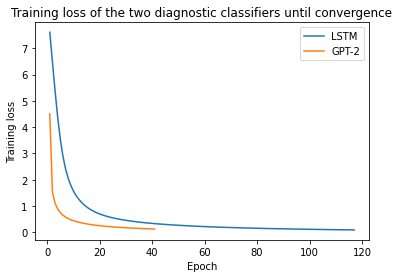

In [34]:
import matplotlib.pyplot as plt

lstm_x = list(range(1, (len(lstm_train_loss[:-4]) + 1)))
lstm_y = lstm_train_loss[:-4]
plt.plot(lstm_x, lstm_y, label = "LSTM")

transformer_x = list(range(1, (len(transformer_train_loss[:-4]) + 1)))
transformer_y = transformer_train_loss[:-4]
plt.plot(transformer_x, transformer_y, label = "GPT-2")

plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('Training loss of the two diagnostic classifiers until convergence')
plt.legend()
plt.show()

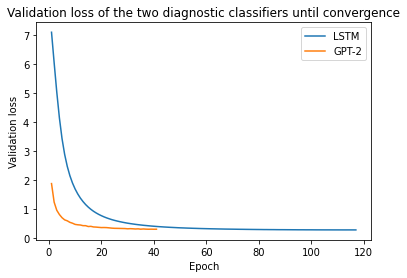

In [35]:
lstm_x = list(range(1, (len(lstm_valid_loss[:-4]) + 1)))
lstm_y = lstm_valid_loss[:-4]
plt.plot(lstm_x, lstm_y, label = "LSTM")

transformer_x = list(range(1, (len(transformer_valid_loss[:-4]) + 1)))
transformer_y = transformer_valid_loss[:-4]
plt.plot(transformer_x, transformer_y, label = "GPT-2")

plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.title('Validation loss of the two diagnostic classifiers until convergence')
plt.legend()
plt.show()

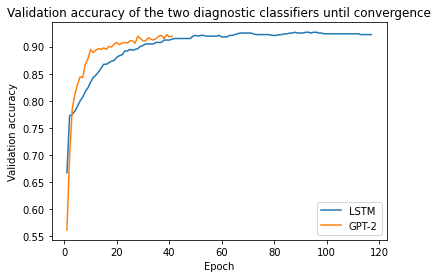

In [36]:
lstm_x = list(range(1, (len(lstm_valid_acc[:-4]) + 1)))
lstm_y = lstm_valid_acc[:-4]
plt.plot(lstm_x, lstm_y, label = "LSTM")

transformer_x = list(range(1, (len(transformer_valid_acc[:-4]) + 1)))
transformer_y = transformer_valid_acc[:-4]
plt.plot(transformer_x, transformer_y, label = "GPT-2")

plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.title('Validation accuracy of the two diagnostic classifiers until convergence')
plt.legend()
plt.show()

**Conclusion:**

We see that the Diagnostic Classifier performs very well (>90% accuracy) on the representations of both models. This indicates that both the LSTM and Transformer encode linguistic features into their representations.

Interestingly, we see that the Diagnostic Classifier performs best on the LSTM, indicating that this middel is slightly better at encoding linguistic features than the Transformer. However, the Diagnostic Classifier on the Transformer converged in significantly fewer steps and started of at a better accuracy (about 85%) than on the LSTM model (about 76%).

**CONCLUSIE IS NOG NIET DEFINITIEF**

# Validating probing results with control tasks
In this section we will examine the faithfulness of the probing results using control tasks. We do this by creating a control task that predicts (pos_tag, token) pairs. We then train a Diagnostic Classifier on the hidden states of the Transformer model and the LSTM model with this control task.

We start by creating a control task. Then, we train our Diagnostic Classifier with this task on the encodings from the GPT-2 transformer and the encodings from the Gulordava LSTM model. Lastly, we compare this with the performance on the real task and calculate the selectivity.

First, we create a function that generates a new vocabulary that contains (pos_tag, token) pairs instead of a vocabulary that is solely based on the POS tag.

In [60]:
import random

# function that fetches the control tags
def fetch_control_tags(ud_parses: List[TokenList], pos_vocab_length, control_vocab=None) -> Tensor:
    # check if the vocabulary is None
    if control_vocab is None:
        # create a new vocab
        control_vocab = defaultdict()
    
    # create a list of tags from the input
    all_tags = []
    
    # loop over the parsed sentences
    for sentence in ud_parses:    
        # loop over the words in the parsed sentence
        for word in sentence:
            # get the token of the word
            token = word['form']
            
            # check if the token does not exist in the vocabulary
            if token not in control_vocab:
                # create a new entry, which is a random number in the range of the pos_vocab_length
                control_vocab[token] = random.randrange(pos_vocab_length)
            
            # add tag to the tags list
            all_tags.append(torch.tensor(control_vocab[token]))
    
    # stack the tags into a tensor
    all_tags = torch.stack(all_tags, dim=0)
    
    # return the tags and vocabulary
    return all_tags, control_vocab

Secondly, we create a new version of our data creation function.

In [61]:
# function that creates the control data
def create_control_data(filename: str, lm, w2i, pos_vocab_length, pos_vocab=None):
    ud_parses = parse_corpus(filename)
    
    sen_reps = fetch_sen_reps(ud_parses, lm, w2i)
    pos_tags, pos_vocab = fetch_control_tags(ud_parses, pos_vocab_length, control_vocab=pos_vocab)
    
    return sen_reps, pos_tags, pos_vocab

In [62]:
# function to get the correct control data for each of the models
def create_pos_control_data(pos_vocab_length, model_used='Transformer'):
    # check which model to use
    if (model_used == 'Transformer'):
        lm = model
        w2i = tokenizer
    else:
        lm = lstm
        w2i = vocab
    use_sample = True

    train_x, train_y, train_vocab = create_control_data(
        os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-train.conllu'),
        lm, 
        w2i,
        pos_vocab_length
    )

    dev_x, dev_y, _ = create_control_data(
        os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-dev.conllu'),
        lm, 
        w2i,
        pos_vocab_length,
        pos_vocab=train_vocab
    )

    test_x, test_y, _ = create_control_data(
        os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-test.conllu'),
        lm,
        w2i,
        pos_vocab_length,
        pos_vocab=train_vocab
    )
    
    # return the data
    return train_x, train_y, dev_x, dev_y, test_x, test_y

Now we can evaluate our Diagnostic Classifier on the new control task.

In [64]:
# get the data for the transformer model
print('Loading data..')
train_x, train_y, dev_x, dev_y, test_x, test_y = create_pos_control_data(transformer_vocab_length, 'Transformer')
print('Data loaded')

# combine train and validation datasets
x_train = torch.cat((train_x, dev_x), dim=0)
y_train = torch.cat((train_y, dev_y), dim=0)

# train the diagnostic classifier
print('Starting training..')
trained_transformer_control_dc = train_dc(DiagnosticClassifier, x_train, y_train, device, batch_size=24, max_epochs=200)
print('Training finished')

# get the transformer data
transformer_control_train_loss = trained_transformer_control_dc.history[:, 'train_loss']
transformer_control_valid_loss = trained_transformer_control_dc.history[:, 'valid_loss']
transformer_control_valid_acc = trained_transformer_control_dc.history[:, 'valid_acc']

# run the test data through the model
transformer_control_test_preds = trained_transformer_control_dc.predict(test_x)
transformer_control_test_acc = accuracy_score(test_y, transformer_control_test_preds)

# save the results
print('Saving results..')
data = {}
data['train_loss'] = transformer_control_train_loss
data['valid_loss'] = transformer_control_valid_loss
data['valid_acc'] = transformer_control_valid_acc
data['test_acc'] = transformer_control_test_acc
with open('model_results/transformer_control_dc.txt', 'w') as outfile:
    json.dump(data, outfile)
print('Results saved')

Loading data..
Data loaded
Starting training..
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        4.4968       0.2219        2.6526  1.8600
      2        2.4152       0.3069        2.3576  1.8890
      3        2.1837       0.3545        2.2327  1.9600
      4        2.0325       0.3689        2.1567  1.9390
      5        1.9175       0.3804        2.1097  1.8650
      6        1.8213       0.3862        2.0677  1.8780
      7        1.7448       0.3963        2.0228  1.8750
      8        1.6762       0.4049        2.0083  1.8800
      9        1.6164       0.4092        1.9827  1.9120
     10        1.5603       0.4092        1.9631  1.8680
     11        1.5109       0.4193        1.9433  1.8900
     12        1.4664       0.4107        1.9458  1.9360
     13        1.4248       0.4164        1.9263  1.9910
     14        1.3897       0.4135        1.9315  2.1030
     15        1.3512       0.4294       

In [ ]:
#import json

# or load the results from an earlier run
#with open('model_results/transformer_control_dc.txt') as json_file:
    #data = json.load(json_file)
    #transformer_control_train_loss = data['train_loss']
    #transformer_control_valid_loss = data['valid_loss']
    #transformer_control_valid_acc = data['valid_acc']
    #transformer_control_test_acc = data['test_acc']

In [65]:
# get the data for the LSTM model
print('Loading data..')
train_x, train_y, dev_x, dev_y, test_x, test_y = create_pos_control_data(lstm_vocab_length, 'LSTM')
print('Data loaded')

# combine train and validation datasets
x_train = torch.cat((train_x, dev_x), dim=0)
y_train = torch.cat((train_y, dev_y), dim=0)

# train the diagnostic classifier
print('Starting training..')
trained_lstm_control_dc = train_dc(DiagnosticClassifier, x_train, y_train, device, batch_size=24, max_epochs=200)
print('Training finished')

# get the lstm data
lstm_control_train_loss = trained_lstm_control_dc.history[:, 'train_loss']
lstm_control_valid_loss = trained_lstm_control_dc.history[:, 'valid_loss']
lstm_control_valid_acc = trained_lstm_control_dc.history[:, 'valid_acc']

# run the test data through the model
lstm_control_test_preds = trained_lstm_control_dc.predict(test_x)
lstm_control_test_acc = accuracy_score(test_y, lstm_control_test_preds)

# save the results
print('Saving results..')
data = {}
data['train_loss'] = lstm_control_train_loss
data['valid_loss'] = lstm_control_valid_loss
data['valid_acc'] = lstm_control_valid_acc
data['test_acc'] = lstm_control_test_acc
with open('model_results/lstm_control_dc.txt', 'w') as outfile:
    json.dump(data, outfile)
print('Results saved')

Loading data..
Data loaded
Starting training..
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        7.7049       0.2666        7.3113  1.7240
      2        6.7769       0.3170        6.4875  1.6980
      3        5.8807       0.3343        5.7036  1.6900
      4        5.0635       0.3357        5.0152  1.6620
      5        4.3899       0.3444        4.4733  1.6770
      6        3.8834       0.3444        4.0709  1.6390
      7        3.5107       0.3487        3.7673  1.6570
      8        3.2295       0.3501        3.5330  1.7030
      9        3.0107       0.3559        3.3438  1.6630
     10        2.8345       0.3617        3.1906  1.6770
     11        2.6885       0.3674        3.0591  1.6350
     12        2.5652       0.3703        2.9475  1.6180
     13        2.4589       0.3718        2.8513  1.7550
     14        2.3654       0.3790        2.7665  1.6400
     15        2.2828       0.3804       

In [ ]:
#import json

# or load the results from an earlier run
#with open('model_results/lstm_control_dc.txt') as json_file:
    #data = json.load(json_file)
    #lstm_control_train_loss = data['train_loss']
    #lstm_control_valid_loss = data['valid_loss']
    #lstm_control_valid_acc = data['valid_acc']
    #lstm_control_test_acc = data['test_acc']

Now we can compare the results of the two different diagnostic classifiers on the control task.

In [67]:
print('LSTM diagnostic classifier on control task after convergence:')
print(f'Train loss = {lstm_control_train_loss[-4]:.4f}')
print(f'Validation loss = {lstm_control_valid_loss[-4]:.4f}')
print(f'Validation accuracy = {lstm_control_valid_acc[-4]:.4f}')
print(f'Test accuracy = {lstm_control_test_acc:.4f}')

LSTM diagnostic classifier on control task after convergence:
Train loss = 1.0300
Validation loss = 1.9005
Validation accuracy = 0.4625
Test accuracy = 0.4761


In [68]:
print('GPT-2 diagnostic classifier on control task after convergence:')
print(f'Train loss = {transformer_control_train_loss[-4]:.4f}')
print(f'Validation loss = {transformer_control_valid_loss[-4]:.4f}')
print(f'Validation accuracy = {transformer_control_valid_acc[-4]:.4f}')
print(f'Test accuracy = {transformer_control_test_acc:.4f}')

GPT-2 diagnostic classifier on control task after convergence:
Train loss = 1.1588
Validation loss = 1.8933
Validation accuracy = 0.4395
Test accuracy = 0.4640


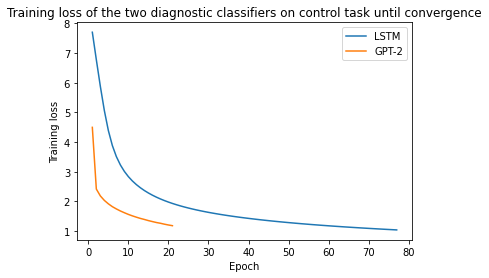

In [69]:
import matplotlib.pyplot as plt

lstm_x = list(range(1, (len(lstm_control_train_loss[:-4]) + 1)))
lstm_y = lstm_control_train_loss[:-4]
plt.plot(lstm_x, lstm_y, label = "LSTM")

transformer_x = list(range(1, (len(transformer_control_train_loss[:-4]) + 1)))
transformer_y = transformer_control_train_loss[:-4]
plt.plot(transformer_x, transformer_y, label = "GPT-2")

plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('Training loss of the two diagnostic classifiers on control task until convergence')
plt.legend()
plt.show()

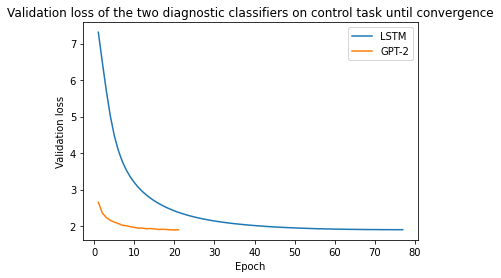

In [70]:
lstm_x = list(range(1, (len(lstm_control_valid_loss[:-4]) + 1)))
lstm_y = lstm_control_valid_loss[:-4]
plt.plot(lstm_x, lstm_y, label = "LSTM")

transformer_x = list(range(1, (len(transformer_control_valid_loss[:-4]) + 1)))
transformer_y = transformer_control_valid_loss[:-4]
plt.plot(transformer_x, transformer_y, label = "GPT-2")

plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.title('Validation loss of the two diagnostic classifiers on control task until convergence')
plt.legend()
plt.show()

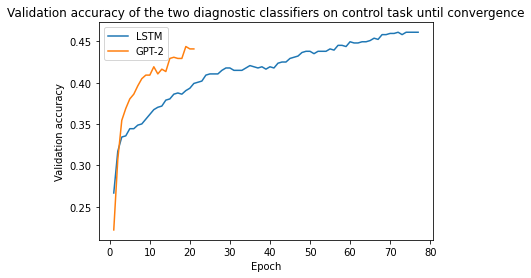

In [71]:
lstm_x = list(range(1, (len(lstm_control_valid_acc[:-4]) + 1)))
lstm_y = lstm_control_valid_acc[:-4]
plt.plot(lstm_x, lstm_y, label = "LSTM")

transformer_x = list(range(1, (len(transformer_control_valid_acc[:-4]) + 1)))
transformer_y = transformer_control_valid_acc[:-4]
plt.plot(transformer_x, transformer_y, label = "GPT-2")

plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.title('Validation accuracy of the two diagnostic classifiers on control task until convergence')
plt.legend()
plt.show()

Now we will look at the selectivity of our Diagnostic Classifiers.

In [72]:
print('LSTM diagnostic classifier:')
print(f'Real task test accuracy = {lstm_test_acc:.4f}')
print(f'Control task test accuracy = {lstm_control_test_acc:.4f}')
print(f'Selectivity = {(lstm_test_acc - lstm_control_test_acc):.4f}')

LSTM diagnostic classifier:
Real task test accuracy = 0.8630
Control task test accuracy = 0.4761
Selectivity = 0.3868


In [73]:
print('Transformer diagnostic classifier:')
print(f'Real task test accuracy = {transformer_test_acc:.4f}')
print(f'Control task test accuracy = {transformer_control_test_acc:.4f}')
print(f'Selectivity = {(transformer_test_acc - transformer_control_test_acc):.4f}')

Transformer diagnostic classifier:
Real task test accuracy = 0.8699
Control task test accuracy = 0.4640
Selectivity = 0.4059


**Conclusion:**

We see that the Diagnostic Classifier performs very poorly on the control task (<50% validation and test accuracy) on the representations of both models. This indicates that the good performance on the real task does not come from the fact that the Diagnostic Classifier is strong enough to learn any mapping. This is backed up by the high selectivity that we see for both Diagnostic Classifiers (around 40%). Therefore, the good performance on the real task comes from the fact that the Transformer and LSTM model are able to capture linguistic features like POS-tags in their hidden states.

**CONCLUSIE IS NOG NIET DEFINITIEF**

# Notion of syntactic structure
In this section we will examine whether transformer models have a stronger notion of syntactic structure than recurrent models? We do this by applying our structural probe on the representations of the GPT-2 transformer model and the representations of the Gulordava LSTM model.

We start by applying our structural probe on the encodings from the GPT-2 transformer and applying our structural probe on the encoding from the Gulordava LSTM model. We then compare the performance of the probe on both models.